<a href="https://colab.research.google.com/github/trehansalil/Py_Projects/blob/master/News_Summarization/experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymongo[srv] transformers emoji rouge-score spacy seaborn scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.0/670.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 24.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 34.0 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=e1c9361471b5def00c027d4382dc1c617e97ec63d2404ebe3033358b0e2a024e
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [2]:
!kaggle datasets download -d shashichander009/inshorts-news-data

Dataset URL: https://www.kaggle.com/datasets/shashichander009/inshorts-news-data
License(s): unknown
 88% 11.0M/12.6M [00:01<00:00, 11.5MB/s]
100% 12.6M/12.6M [00:01<00:00, 7.66MB/s]


In [3]:
!unzip inshorts-news-data.zip

Archive:  inshorts-news-data.zip
  inflating: Inshorts Cleaned Data.xlsx  


In [4]:
from pymongo import MongoClient
import pandas as pd
from datetime import datetime, timezone
import os
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW


# Requires the PyMongo package.
# https://api.mongodb.com/python/current

from google.colab import userdata
MONGO_DB_URI = userdata.get('MONGO_DB_URI')

client = MongoClient(MONGO_DB_URI)
filter={
    'updated_at': {
        '$gte': datetime(2023, 10, 1, 0, 0, 0, tzinfo=timezone.utc),
        '$lt': datetime(2025, 1, 1, 0, 0, 0, tzinfo=timezone.utc)
    },
    'category': {
        '$ne': []
    }
}
sort=list({
    'updated_at': -1
}.items())

result = client['inshorts_db']['news_data'].find(
  filter=filter,
  sort=sort
)

df = pd.DataFrame.from_dict(result)

irrelevant_categories = [i for i in df['category'].explode().value_counts().loc[df['category'].explode().value_counts()<1000].index]
relevant_categories = [i for i in df['category'].explode().value_counts().loc[df['category'].explode().value_counts()>=1000].index]

print(irrelevant_categories)

df['category'] = df['category'].apply(lambda x: [i for i in x if i not in irrelevant_categories])

df.drop(index=df.loc[df['category'].apply(lambda x: x==[])].index, inplace=True)

df = df.reset_index(drop=True)

df.head()

['IPL', 'Lifestyle', 'EXPLAINERS', 'Feel_Good_Stories', 'experiment', 'Israel-Hamas_War', 'cricket', 'city', 'Russia-Ukraine_Conflict', 'crime', 'bollywood', 'Coronavirus', 'football', 'cryptocurrency', 'arts_and_entertainment', 'facts', 'Union_Budget_2023-24', 'Union_Budget_2024', 'environment', 'ODI_World_Cup_2023']


,_id,inshorts_url,author,category,created_at,date,datetime,day,headlines,image_url,original_source,read_more,relevancy_tags,text,updated_at
0,6650c7257fcaca29f836897c,https://inshorts.com/en/news/feel-i-played-t20...,Anmol Sharma,[sports],2024-05-24 17:59:00.724,2024-05-24,2024-05-24 16:24:25,Friday,Feel I played T20 World Cup 2022 because of RC...,https://nis-gs.pix.in/inshorts/images/v1/varia...,YouTube,https://youtu.be/glTq-9wbR-g?utm_campaign=full...,[cricket],"Dinesh Karthik, who retired from IPL, said he ...",2024-05-24 17:59:00.724
1,6650c7257fcaca29f8368894,https://inshorts.com/en/news/i-wanted-to-marry...,Daisy Mowke,[national],2024-05-24 17:59:00.446,2024-05-24,2024-05-24 16:45:37,Friday,"I wanted to marry a girl from different caste,...",https://nis-gs.pix.in/inshorts/images/v1/varia...,NDTV,https://www.ndtv.com/india-news/siddaramaiah-s...,"[politics, national]","Karnataka CM Siddaramaiah, while speaking at a...",2024-05-24 17:59:00.446
2,6650c7247fcaca29f8368813,https://inshorts.com/en/news/if-i-was-him-i-wo...,Anmol Sharma,[sports],2024-05-24 17:59:00.168,2024-05-24,2024-05-24 16:54:09,Friday,"If I was him, I would definitely have given up...",https://nis-gs.pix.in/inshorts/images/v1/varia...,FPJ,https://www.freepressjournal.in/amp/sports/i-w...,[cricket],CWG and Asian Games gold medallist Dipika Pall...,2024-05-24 17:59:00.168
3,6650cf527fcaca29f84884d2,https://inshorts.com/en/news/2-policemen-who-d...,Medhaa Gupta,[national],2024-05-24 17:58:59.891,2024-05-24,2024-05-24 17:06:52,Friday,2 policemen who didn't inform control room abo...,https://nis-gs.pix.in/inshorts/images/v1/varia...,PTI,https://x.com/PTI_News/status/1794021629716021...,[national],Pune Police Commissioner Amitesh Kumar has sai...,2024-05-24 17:58:59.891
4,6650d07e7fcaca29f84bad26,https://inshorts.com/en/news/us-leader-ben-bak...,Ankush Verma,[world],2024-05-24 17:58:59.569,2024-05-24,2024-05-24 17:17:59,Friday,"US leader Ben Baker's daughter, son-in-law sho...",https://nis-gs.pix.in/inshorts/images/v1/varia...,Hindustan Times,https://www.hindustantimes.com/world-news/us-n...,[world],US leader Ben Baker's daughter and son-in-law ...,2024-05-24 17:58:59.569


In [5]:

kf = pd.read_excel('/content/Inshorts Cleaned Data.xlsx')[['Headline', 'Short']].rename(columns={'Headline': 'summary', 'Short': 'text'})

kf.head()

,summary,text
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...


In [6]:
kf['text'][0], kf['summary'][0]

('The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons.',
 '4 ex-bank officials booked for cheating bank of ₹209 crore')

In [7]:
df['category'].explode().value_counts()

category
national               5964
business               3906
sports                 3573
entertainment          2878
world                  2822
politics               2610
technology             1755
miscellaneous          1739
hatke                  1590
startup                1446
LOK_SABHA_ELECTIONS    1263
Health___Fitness       1173
science                1145
travel                 1143
fashion                1142
education              1056
automobile             1051
Name: count, dtype: int64

In [8]:
df['original_source'].value_counts()

original_source
Free Press Journal    1641
Hindustan Times       1258
Times Now             1248
The Indian Express     728
News18                 686
                      ... 
Nasa                     1
cms.news9live.com        1
 The Independent         1
Knight Frank             1
Allensolly               1
Name: count, Length: 605, dtype: int64

In [9]:
df.drop(columns=['inshorts_url', 'author', 'created_at', 'updated_at',
                 'datetime', 'date', 'day', 'original_source',
                 'read_more', 'relevancy_tags'],inplace=True)

### News Summarization

In [10]:
import pandas as pd
import numpy as np
import spacy
from IPython.display import Image

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [11]:
config = {'min_text_len':40,
          'max_text_len':60,
          'max_summary_len':30,
          'latent_dim':300,
          'embedding_dim':200}

In [12]:
raw = df[['text', 'headlines']].rename(columns={'headlines': 'summary'})

raw = pd.concat([raw, kf], axis=0).reset_index(drop=True)

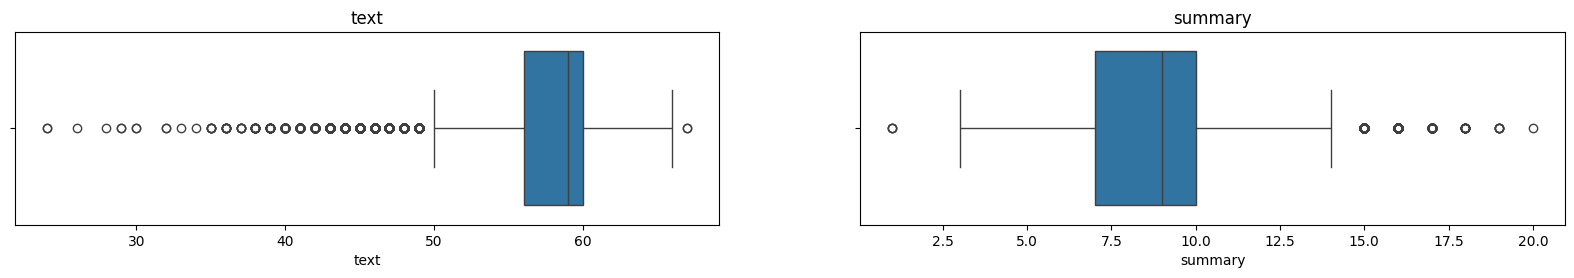

In [13]:
fig, ax = plt.subplots(1,2,figsize=(20,2.5))
sns.boxplot(raw['text'].str.split().str.len(),ax=ax[0],orient="h")
ax[0].set_title('text')
sns.boxplot(raw['summary'].str.split().str.len(),ax=ax[1],orient="h")
ax[1].set_title('summary')

fig.show()

In [14]:
print(f'berore filtering: {raw.shape}')
pre = raw.loc[(raw['text'].str.split(" ").str.len()>config['min_text_len']) & (raw['text'].str.split(" ").str.len()<config['max_text_len'])].reset_index(drop=True)
print(f'after filtering: {pre.shape}')

berore filtering: (80141, 2)
after filtering: (48961, 2)


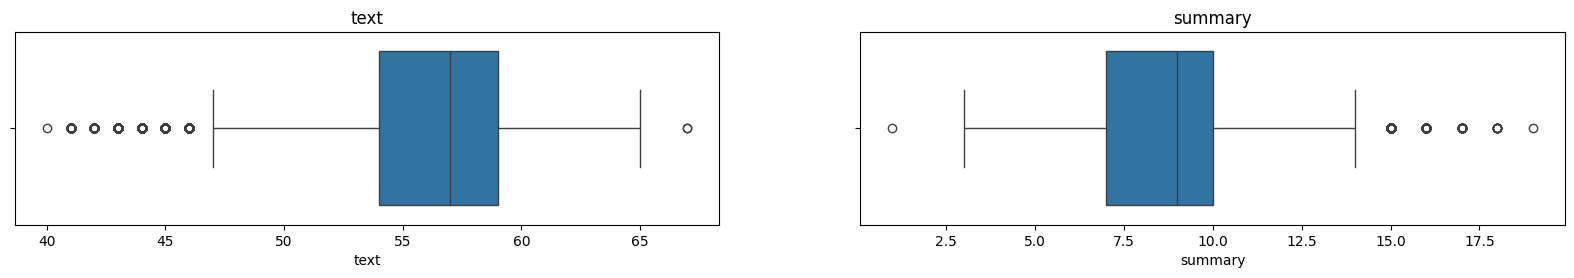

In [15]:
fig, ax = plt.subplots(1,2,figsize=(20,2.5))
sns.boxplot(pre['text'].str.split().str.len(),ax=ax[0],orient="h")
ax[0].set_title('text')
sns.boxplot(pre['summary'].str.split().str.len(),ax=ax[1],orient="h")
ax[1].set_title('summary')

fig.show()

In [16]:
ind = 1
print(f'Text: {pre.text[ind]}')
print('')
print(f'Summary: {pre.summary[ind]}')
print('')
print(f'Text length: {len(pre.text[ind].split())}')
print(f'Summary length: {len(pre.summary[ind].split())}')

Text: Filmmaker Pahlaj Nihalani, in an interview, called Govinda "unpredictable" and how director David Dhawan "manipulated" the actor. "David...is a selfish person...I still don't know what exactly he told him, but Govinda never showed up on the sets of 'Bhai Bhai'...Right from there, the misunderstanding between us increased," he said. "He even shelved 'Avatar' on David Dhawan's advice," Pahlaj added.

Summary: David Dhawan is a selfish person, he manipulated Govinda: Pahlaj

Text length: 59
Summary length: 10


In [17]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Input, InputLayer, RNN, SimpleRNN, LSTM, GRU, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

import string

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
import re

# remove non-alphabetic character
def text_strip(sentence):

    sentence = re.sub("(\\t)"," ",str(sentence)).lower()
    sentence = re.sub("(\\r)"," ",str(sentence)).lower()
    sentence = re.sub("(\\n)"," ",str(sentence)).lower()

    # remove - if it occours more than one time
    sentence = re.sub("(--+)"," ",str(sentence)).lower()

    # remove . if it occours more than one time
    sentence = re.sub("(\.\.+)"," ",str(sentence)).lower()

    # remove special characters
    sentence = re.sub(r"[-<>()|&©⌀\[\]\'\",;?*!]"," ",str(sentence)).lower()

    # remove \x9* in text
    sentence = re.sub(r"(\\x9\d)"," ",str(sentence)).lower()

    # replace CH# and CHG# to CM_NUM
    sentence = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)","CM_NUM",str(sentence)).lower()

    # remove punctuations at the end of the word
    sentence = re.sub("(\.\s+)"," ",str(sentence)).lower()
    sentence = re.sub("(\-\s+)"," ",str(sentence)).lower()
    sentence = re.sub("(\:\s+)"," ",str(sentence)).lower()

    # remove multiple spaces
    sentence = re.sub("(\s+)"," ",str(sentence)).lower()

    return sentence

In [20]:
pre['cleaned_text'] = pre.text.apply(lambda x: text_strip(x))
pre['cleaned_summary'] = pre.summary.apply(lambda x: '__START__' + text_strip(x) + '__END__')
pre['cleaned_summary'] = pre['cleaned_summary'].apply(lambda x: 'sostok ' + x + ' eostok')
pre

,text,summary,cleaned_text,cleaned_summary
0,Pune Police Commissioner Amitesh Kumar has sai...,2 policemen who didn't inform control room abo...,pune police commissioner amitesh kumar has sai...,sostok __START__2 policemen who didn t inform ...
1,"Filmmaker Pahlaj Nihalani, in an interview, ca...","David Dhawan is a selfish person, he manipulat...",filmmaker pahlaj nihalani in an interview call...,sostok __START__david dhawan is a selfish pers...
2,Actress Avneet Kaur has shared a video of her ...,Avneet Kaur touches the ground while walking r...,actress avneet kaur has shared a video of her ...,sostok __START__avneet kaur touches the ground...
3,Gymnast Dipa Karmakar has failed to qualify fo...,Gymnast Dipa Karmakar fails to qualify for Par...,gymnast dipa karmakar has failed to qualify fo...,sostok __START__gymnast dipa karmakar fails to...
4,Payal Kapadia and the cast of her film 'All We...,Payal Kapadia's film earns 8-minute standing o...,payal kapadia and the cast of her film all we ...,sostok __START__payal kapadia s film earns 8 m...
...,...,...,...,...
48956,A beedi tycoon from Kerala&#39;s Thrissur dist...,Kerala tycoon guilty of guard&#39;s murder wit...,a beedi tycoon from kerala #39 s thrissur dist...,sostok __START__kerala tycoon guilty of guard ...
48957,Maharashtra’s state cultural department is org...,Maharashtra to host Raigad festival from Jan 21,maharashtra’s state cultural department is org...,sostok __START__maharashtra to host raigad fes...
48958,"Two militants, who were reportedly holed up in...",2 militants killed in encounter in J&amp;K&#39...,two militants who were reportedly holed up ins...,sostok __START__2 militants killed in encounte...
48959,Researchers from the Georgia Institute of Tech...,New lab for remote access to robots being built,researchers from the georgia institute of tech...,sostok __START__new lab for remote access to r...


In [21]:
print(pre.shape)
post_pre = pre[((pre['cleaned_text'].str.split().str.len()<=config['max_text_len']) & (pre['summary'].str.split().str.len()<=(config['max_summary_len']+4)))].copy()
post_pre = post_pre.reset_index(drop=True)
print(post_pre.shape)
post_pre = post_pre.drop(['text','summary'],axis=1)
post_pre = post_pre.rename(columns = {'cleaned_text':'text',
                                      'cleaned_summary':'summary'})
post_pre

(48961, 4)
(29859, 4)


,text,summary
0,actress avneet kaur has shared a video of her ...,sostok __START__avneet kaur touches the ground...
1,gymnast dipa karmakar has failed to qualify fo...,sostok __START__gymnast dipa karmakar fails to...
2,payal kapadia and the cast of her film all we ...,sostok __START__payal kapadia s film earns 8 m...
3,popular tv actress rubina dilaik took to her i...,sostok __START__rubina dilaik’s x account gets...
4,kabosu the famous shiba inu known for being th...,sostok __START__ doge meme dog kabosu dies__EN...
...,...,...
29854,microsoft on tuesday announced the acquisition...,sostok __START__microsoft buys custom version ...
29855,a beedi tycoon from kerala #39 s thrissur dist...,sostok __START__kerala tycoon guilty of guard ...
29856,maharashtra’s state cultural department is org...,sostok __START__maharashtra to host raigad fes...
29857,two militants who were reportedly holed up ins...,sostok __START__2 militants killed in encounte...


In [22]:
x_train, x_valid, y_train, y_valid = train_test_split(np.array(post_pre['text']),
                                                      np.array(post_pre['summary']),
                                                      test_size = 0.1,
                                                      shuffle=True)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((26873,), (2986,), (26873,), (2986,))

In [23]:

text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(list(x_train))

In [24]:
def get_rare_words(text_col):

    # prepare a tokenizer on testing data
    text_tokenizer = Tokenizer()
    text_tokenizer.fit_on_texts(list(text_col))

    thresh = 5
    cnt = 0
    total_count = 0

    for key, value in text_tokenizer.word_counts.items():
        total_count = total_count + 1
        if value < thresh:
            cnt = cnt + 1

    print('% of rare words in vocabulary:',(cnt/total_count)*100)

    return cnt, total_count


x_train_cnt, x_train_total_count = get_rare_words(x_train)

% of rare words in vocabulary: 68.2739244951712


In [25]:
x_tokenizer = Tokenizer(num_words = x_train_total_count-x_train_cnt)
x_tokenizer.fit_on_texts(list(x_train))

# Convert text sequence to integer sequence
x_tr_seq = x_tokenizer.texts_to_sequences(x_train)
x_val_seq = x_tokenizer.texts_to_sequences(x_valid)

# pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq, maxlen = config['max_text_len'],padding='post')
x_val = pad_sequences(x_val_seq, maxlen = config['max_text_len'],padding='post')

# Size of the vocab (+1 for padding)
x_voc = x_tokenizer.num_words +1

print('vocabulary size: ', x_voc)

vocabulary size:  18069


In [26]:

y_train_cnt, y_train_total_cnt = get_rare_words(y_train)

% of rare words in vocabulary: 73.32917414021681


In [27]:
y_tokenizer = Tokenizer(num_words = y_train_total_cnt-y_train_cnt)
y_tokenizer.fit_on_texts(list(y_train))

# Convert text sequence to integer sequence
y_tr_seq = y_tokenizer.texts_to_sequences(y_train)
y_val_seq = y_tokenizer.texts_to_sequences(y_valid)

# pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen = config['max_text_len'],padding='post')
y_val = pad_sequences(y_val_seq, maxlen = config['max_text_len'],padding='post')

# Size of the vocab (+1 for padding)
y_voc = y_tokenizer.num_words +1

print('vocabulary size: ',y_voc)

vocabulary size:  6841


In [28]:
latent_dim = config['latent_dim']
embedding_dim = config['embedding_dim']
max_text_len = config['max_text_len']
max_summary_len = config['max_summary_len']

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

# Embedding layer
enc_emb = Embedding(x_voc,embedding_dim,trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
(encoder_output1,state_h,state_c) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
(encoder_output2,state_h,state_c) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
(encoder_outputs,state_h,state_c) = encoder_lstm3(encoder_output2)

# Decoder
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc,embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state)= decoder_lstm(dec_emb,initial_state=[state_h,state_c])

# Dense Layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the Model
model = Model([encoder_inputs, decoder_inputs],decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 60, 200)              3613800   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 60, 300),            601200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                              

In [29]:
model.compile(optimizer='adam',loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model_name = './model.h5'

save_model = tf.keras.callbacks.ModelCheckpoint(filepath=model_name,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)
# Eralystopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [30]:
history = model.fit(
    [x_tr,y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0],y_tr.shape[1],1)[:, 1:],
    epochs =500,
    callbacks = [es, save_model],
    batch_size = 512,
    validation_data = ([x_val,y_val[:, :-1]],
                       y_val.reshape(y_val.shape[0],y_val.shape[1],1)[:, 1:])
                    )

Epoch 1/500
53/53 [==============================] - ETA: 0s - loss: 2.6247 - accuracy: 0.7996
Epoch 1: val_loss improved from inf to 1.23504, saving model to ./model.h5
53/53 [==============================] - 97s 1s/step - loss: 2.6247 - accuracy: 0.7996 - val_loss: 1.2350 - val_accuracy: 0.8297
Epoch 2/500
53/53 [==============================] - ETA: 0s - loss: 1.2736 - accuracy: 0.8254
Epoch 2: val_loss did not improve from 1.23504
53/53 [==============================] - 72s 1s/step - loss: 1.2736 - accuracy: 0.8254 - val_loss: 1.3576 - val_accuracy: 0.8182
Epoch 3/500
53/53 [==============================] - ETA: 0s - loss: 1.2177 - accuracy: 0.8365
Epoch 3: val_loss improved from 1.23504 to 1.08952, saving model to ./model.h5
53/53 [==============================] - 69s 1s/step - loss: 1.2177 - accuracy: 0.8365 - val_loss: 1.0895 - val_accuracy: 0.8616
Epoch 4/500
53/53 [==============================] - ETA: 0s - loss: 1.1043 - accuracy: 0.8608
Epoch 4: val_loss improved from 

KeyboardInterrupt: 

In [31]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'],label='test')
pyplot.legend()
pyplot.show()

NameError: name 'history' is not defined

In [ ]:
reverse_source_word_index = x_tokenizer.index_word
reverse_target_word_index = y_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
from tqdm import tqdm
actual = []
predicted = []
for i in tqdm(range(0,50)):
    print('Review:', seq2text(x_tr[i]))

    actual.append(seq2summary(y_tr[i]))
    print('Original Summary', actual[-1])

    predicted.append(decode_sequence(x_tr[i].reshape(1,config['max_text_len'])))
    print('Prdicted Summary', predicted[-1])
    print()

prediction_df = pd.DataFrame({'Actual':actual,'Predicted':predicted})
prediction_df.head(10)

In [ ]:
from rouge_score import rouge_scorer

r_score = []
rouge_pr = []
rouge_rc = []
rouge_f = []

scorer = rouge_scorer.RougeScorer(['rougeL','rougeL'],use_stemmer=True)

for index, data in prediction_df.iterrows():
    r_score = scorer.score(data.Actual, data.Predicted)
    pr = list(r_score['rougeL'])[0]
    rc = list(r_score['rougeL'])[1]
    f_meas = list(r_score['rougeL'])[2]

    rouge_pr.append(pr)
    rouge_rc.append(rc)
    rouge_f.append(f_meas)

prediction_df['rouge_pr'] = rouge_pr
prediction_df['rouge_rc'] = rouge_rc
prediction_df['rouge_f'] = rouge_f
prediction_df.head(10)

In [ ]:
prediction_df[['rouge_pr', 'rouge_rc', 'rouge_f']].mean(axis=0)

### Category Prediction

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is",
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-',
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does',
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum',
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend',
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

In [ ]:
from bs4 import BeautifulSoup
import re
import emoji
import string

def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text
    # text = BeautifulSoup(text, 'lxml').get_text()
    # text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    # text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    # text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''
    for p in mapping:
        text = text.replace(p, mapping[p])

    for p in punct:
        text = text.replace(p, f' {p} ')

    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])

    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''
    #Removes awkward spaces
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

df['text'] = df['text'].apply(text_preprocessing_pipeline)

df_labels = df['category'].apply(lambda x: ",".join(x)).str.get_dummies(sep=',')

df = df.join(df_labels)

In [ ]:
len(irrelevant_categories)

19

In [ ]:
len(relevant_categories)

17

In [ ]:
target_cols = [i for i in df_labels.columns]

In [ ]:
import torch


device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 2e-5
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.Text
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df.drop(columns=['_id', 'headlines', 'image_url']), test_size=0.2, random_state=42)


In [ ]:
len(df_train['category'].explode().value_counts().index)

17

In [ ]:
len(df_test['category'].explode().value_counts().index)

17

In [ ]:

train_loader = DataLoader(df_train, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=4, shuffle=True, pin_memory=True)
valid_loader = DataLoader(df_test, batch_size=VALID_BATCH_SIZE,
                          num_workers=4, shuffle=False, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('roberta-base')
#         self.l2 = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(768,5)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
#         output_2 = self.l2(output_1)
        output = self.fc(features)
        return output

model = BERTClass()
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTClass(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer = AdamW(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train(epoch):
    model.train()
    for _,data in enumerate(train_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        if _%500 == 0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 147, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 176, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7080, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 3786

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py", line 3761, in __getitem__
    indexer = self.columns.get_loc(key)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 3655, in get_loc
    raise KeyError(key) from err
KeyError: 3786


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow as tf

class HammingLoss(tf.keras.metrics.Metric):
    def __init__(self, name='hamming_loss', threshold=0.5, mode='multilabel', **kwargs):
        super(HammingLoss, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.mode = mode
        self.total_loss = self.add_weight(name='total_loss', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        if self.mode == 'multilabel':
            y_pred = tf.cast(y_pred > self.threshold, tf.int32)
        elif self.mode == 'multiclassification':
            y_pred = tf.argmax(y_pred, axis=1)
            y_true = tf.argmax(y_true, axis=1)

        hamming_distance = tf.reduce_mean(tf.cast(y_true != y_pred, tf.float32))

        self.total_loss.assign_add(hamming_distance)
        self.count.assign_add(1)

    def result(self):
        return self.total_loss / self.count

    def reset_states(self):
        self.total_loss.assign(0)
        self.count.assign(0)



# Text Preprocessing
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['text'])
X_text = tokenizer.texts_to_sequences(df['text'])
X_text = pad_sequences(X_text, padding='post')

# Category Preprocessing
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['category'])

# Convert category labels to one-hot encoding
y = np.array(y)


model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(len(mlb.classes_), activation='sigmoid'))

metric = HammingLoss(mode='multilabel', threshold=0.8)

optimizer = tf.keras.optimizers.AdamW(
                learning_rate=0.001,
                weight_decay=0.004,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-07,
                amsgrad=False,
                clipnorm=None,
                clipvalue=None,
                global_clipnorm=None,
                use_ema=False,
                ema_momentum=0.99,
                ema_overwrite_frequency=None,
                loss_scale_factor=None,
                gradient_accumulation_steps=None,
                name='adamw',
            )

# Compiling the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', metric])

# Training the model
history = model.fit(X_text, y, epochs=10, batch_size=16, validation_split=0.2)


2024-05-19 18:25:17.806572: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 18:25:17.810026: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 18:25:17.842307: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 18:25:20.242522: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/10


TypeError: Input 'y' of 'NotEqual' Op has type int32 that does not match type int64 of argument 'x'.